In [421]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import GridSearchCV, cross_validate


All questions in this section pertain to two of the datasets listed above in Exam Materials
(training_set_data.csv and unlabeled_data.csv), with the data_dictionary.txt file providing the
metadata needed to understand the contents and formats of each .csv. 

Please note that the data is still in its raw, original form and may require some cleaning and/or standardization.


Imagine we are being asked by one of our clients, ACME X, to predict if a given individual is
uninsured or not (health insurance). Using the data in training_set_data.csv, please train a model
to predict whether each person in the data set is uninsured or not. 


Furthermore, our main contact
at ACME X will need to explain the basics of the model to their smart, but non-technical
coworkers, so interpretability of how the model inputs relate to the predictions will be important.

In [422]:
train = pd.read_csv('training_set_data.csv')
pd.set_option('display.max_columns', 500)
train.head(3)

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,uninsured,household_id
0,1,45,citizen_birth,native_born,15,908.0,62.0,800.0,11.0,35.0,married,not_student,FEMALE,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
1,2,47,citizen_birth,native_born,50,180499.0,49.0,160007.0,20424.0,19.0,married,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
2,4,26,citizen_birth,native_born,0,7367.0,93.0,4.0,20.0,7250.0,never_married,not_student,male,over_five_years_ago,not_reported,English,0,0,1,0,0,0,0,0,2


## EDA

In [423]:
train.sex = train.sex.replace({'FEMALE': 'F'})
train.sex = train.sex.replace({'female': 'F'})

train.sex = train.sex.replace({'MALE': 'M'})
train.sex = train.sex.replace({'male': 'M'})

train.sex.value_counts()

F    30834
M    28763
Name: sex, dtype: int64

In [424]:
train.language.value_counts(normalize=True).count()

91

In [425]:
for val in train.language.values:
    if val != 'English':
        train.language = train.language.replace({val:'not_english'})


In [426]:
train.language.value_counts()

English        49326
not_english    10271
Name: language, dtype: int64

In [427]:
train.race_native_hawaiian.value_counts()

0    59576
1       21
Name: race_native_hawaiian, dtype: int64

In [428]:
# unlabeled = pd.read_csv('unlabeled_data.csv')
# pd.set_option('display.max_columns', 500)
# # unlabeled.head()

In [429]:
train.head()

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,uninsured,household_id
0,1,45,citizen_birth,native_born,15,908.0,62.0,800.0,11.0,35.0,married,not_student,F,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
1,2,47,citizen_birth,native_born,50,180499.0,49.0,160007.0,20424.0,19.0,married,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
2,4,26,citizen_birth,native_born,0,7367.0,93.0,4.0,20.0,7250.0,never_married,not_student,M,over_five_years_ago,not_reported,English,0,0,1,0,0,0,0,0,2
3,5,42,citizen_naturalized,foreign_born,0,22970.0,51.0,46.0,283.0,22590.0,never_married,public_school,M,in_last_five_years,did_not_work,not_english,0,1,0,0,0,0,0,0,3
4,6,79,citizen_naturalized,foreign_born,0,7941.0,23.0,94.0,73.0,7751.0,married,not_student,M,over_five_years_ago,did_not_work,not_english,0,1,0,0,0,0,0,0,3


In [430]:
#Target and independent variables

X = train.drop(['person_id', 'uninsured', 'household_id',  
                 ],  axis=1)
y= train['uninsured']


In [431]:
y.value_counts(normalize=True)

0    0.922479
1    0.077521
Name: uninsured, dtype: float64

## One hot encoder

In [432]:
cont = X.select_dtypes(exclude='object')

cat = X.select_dtypes(include='object')

###  Scaling cont  variables 

In [433]:
for col in cont.columns:
    cont[col]= (cont[col]-min(cont[col]))/(max(cont[col]-min(cont[col])))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [434]:

cont.head()

,age,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other
0,0.355263,0.151515,0.000840,0.000200,0.001584,0.000045,0.000144,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.381579,0.505051,0.170235,0.000158,0.316782,0.083329,0.000078,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.105263,0.000000,0.006933,0.000300,0.000008,0.000082,0.029835,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.315789,0.000000,0.021650,0.000164,0.000091,0.001155,0.092962,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.802632,0.000000,0.007474,0.000074,0.000186,0.000298,0.031897,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [435]:
ehe = OneHotEncoder(drop='first')


In [436]:
tran = ehe.fit_transform(cat).toarray()

In [437]:
tran_df= pd.DataFrame(tran, columns=ehe.get_feature_names(cat.columns))

In [438]:
tran_df.head(2)

,citizen_status_citizen_naturalized,citizen_status_noncitizen,nativity_status_native_born,marital_status_married,marital_status_never_married,marital_status_separated,marital_status_widowed,school_status_private_school,school_status_public_school,sex_M,when_last_worked_in_last_year,when_last_worked_over_five_years_ago,worked_last_week_not_reported,worked_last_week_worked,language_not_english
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [439]:
tran_df.reset_index(inplace=True, drop=True)


In [440]:
cont.reset_index(inplace=True, drop=True)

In [441]:
X = tran_df.join(cont)

In [442]:
X.head(2)

,citizen_status_citizen_naturalized,citizen_status_noncitizen,nativity_status_native_born,marital_status_married,marital_status_never_married,marital_status_separated,marital_status_widowed,school_status_private_school,school_status_public_school,sex_M,when_last_worked_in_last_year,when_last_worked_over_five_years_ago,worked_last_week_not_reported,worked_last_week_worked,language_not_english,age,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.355263,0.151515,0.000840,0.000200,0.001584,0.000045,0.000144,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.381579,0.505051,0.170235,0.000158,0.316782,0.083329,0.000078,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Train test split

In [443]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=28)

In [444]:
y_train.value_counts(normalize=True)

0    0.922232
1    0.077768
Name: uninsured, dtype: float64

### Logistic Regression

In [446]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression( )

model = logreg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [447]:
model.score(X_test, y_test)

0.9248993288590605

In [448]:
y_pred = logreg.predict(X_test)

## to predict if a given individual is uninsured or not (health insurance)

In [471]:
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)

#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[13682    74]
 [ 1045    99]]


 True positive  = 13677
 
 
 False positive = 75


False Negative = 1040


True Negative 104

In [450]:
coef = model.coef_.reshape(-1)

In [472]:
print('True', y_test.values[0:25])
print('Pred', y_pred[0:25])

True [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Pred [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [473]:
print((TP + TN) / float(TP + TN + FP + FN))

print(metrics.accuracy_score(y_test, y_pred))

0.9248993288590605
0.9248993288590605


In [474]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred))

0.0751006711409396
0.07510067114093955


In [479]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(y_test, y_pred))

0.08653846153846154
0.08653846153846154


In [480]:
specificity = TN / (TN + FP)

print(specificity)

0.9946205292236115


## False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

In [483]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.005379470776388485
0.005379470776388451


## Precision: When a positive value is predicted, how often is the prediction correct?

### How "precise" is the classifier when predicting positive instances?

In [484]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred))

0.5722543352601156
0.5722543352601156


In [485]:
logreg.predict(X_test)[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [571]:
logreg.predict_proba(new)
logreg.predict(new)


array([0, 0, 0, ..., 0, 0, 0])

In [502]:
logreg.predict_proba(new)[0:10]

array([[0.84732035, 0.15267965],
       [0.87373017, 0.12626983],
       [0.9537671 , 0.0462329 ],
       [0.97365704, 0.02634296],
       [0.93489221, 0.06510779],
       [0.92529313, 0.07470687],
       [0.95494038, 0.04505962],
       [0.95694298, 0.04305702],
       [0.95435817, 0.04564183],
       [0.98383075, 0.01616925]])

### There is a 0.5 classification threshold

### Class 1 is predicted if probability > 0.5
### Class 0 is predicted if probability < 0.5

In [554]:
# print the first 10 predicted probabilities for class 1
logreg.predict_proba(new)[0:10, 1]

array([0.15267965, 0.12626983, 0.0462329 , 0.02634296, 0.06510779,
       0.07470687, 0.04505962, 0.04305702, 0.04564183, 0.01616925])

In [555]:
y_pred_prob = logreg.predict_proba(new)[:, 1]

In [556]:
y_pred_prob.shape

(20172,)

In [557]:
%matplotlib inline
import matplotlib.pyplot as plt

# adjust the font size 
plt.rcParams['font.size'] = 12

Text(0, 0.5, 'Frequency')

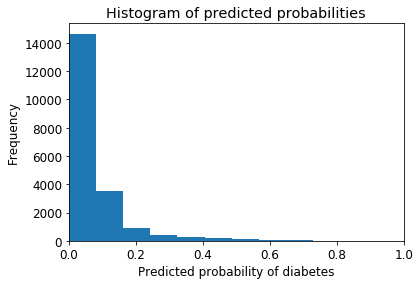

In [558]:
#histogram of predicted probabilities

# 8 bins
plt.hist(y_pred_prob, bins=10)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

In [562]:
## print the first 10 predicted probabilities for class 1

logreg.predict_proba(new)[0:10, 1]

array([0.15267965, 0.12626983, 0.0462329 , 0.02634296, 0.06510779,
       0.07470687, 0.04505962, 0.04305702, 0.04564183, 0.01616925])

In [563]:
y_pred_prob = y_pred_prob.reshape(-1, 1)

In [564]:
from sklearn.preprocessing import binarize
# it will return 1 for all values above 0.3 and 0 otherwise
# results are 2D so we slice out the first column
y_pred_class = binarize(y_pred_prob, 0.3)


In [566]:
y_pred_prob[0:10]

array([[0.15267965],
       [0.12626983],
       [0.0462329 ],
       [0.02634296],
       [0.06510779],
       [0.07470687],
       [0.04505962],
       [0.04305702],
       [0.04564183],
       [0.01616925]])

In [565]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [567]:
print(confusion)

[[13682    74]
 [ 1045    99]]


In [569]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(new, y_pred_class))

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

Unlike precision that only comments on the correct positive predictions out of all positive predictions, recall provides an indication of missed positive predictions.

In this way, recall provides some notion of the coverage of the positive class.

## precision is "how useful the search results are", and recall is "how complete the results are".

F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. 

## Precision: Appropriate when minimizing false positives is the focus.
## Recall: Appropriate when minimizing false negatives is the focus.

In [455]:
df_coef = pd.DataFrame(X_train.columns)

df_coef['features'] = coef

df_coef.columns = ['coef', 'features']

#df['features'] = df_coef.features.sort_values(ascending=False)

df_coef.head()

,coef,features
0,citizen_status_citizen_naturalized,-0.672021
1,citizen_status_noncitizen,0.936262
2,nativity_status_native_born,-0.731879
3,marital_status_married,-0.602316
4,marital_status_never_married,-0.048148


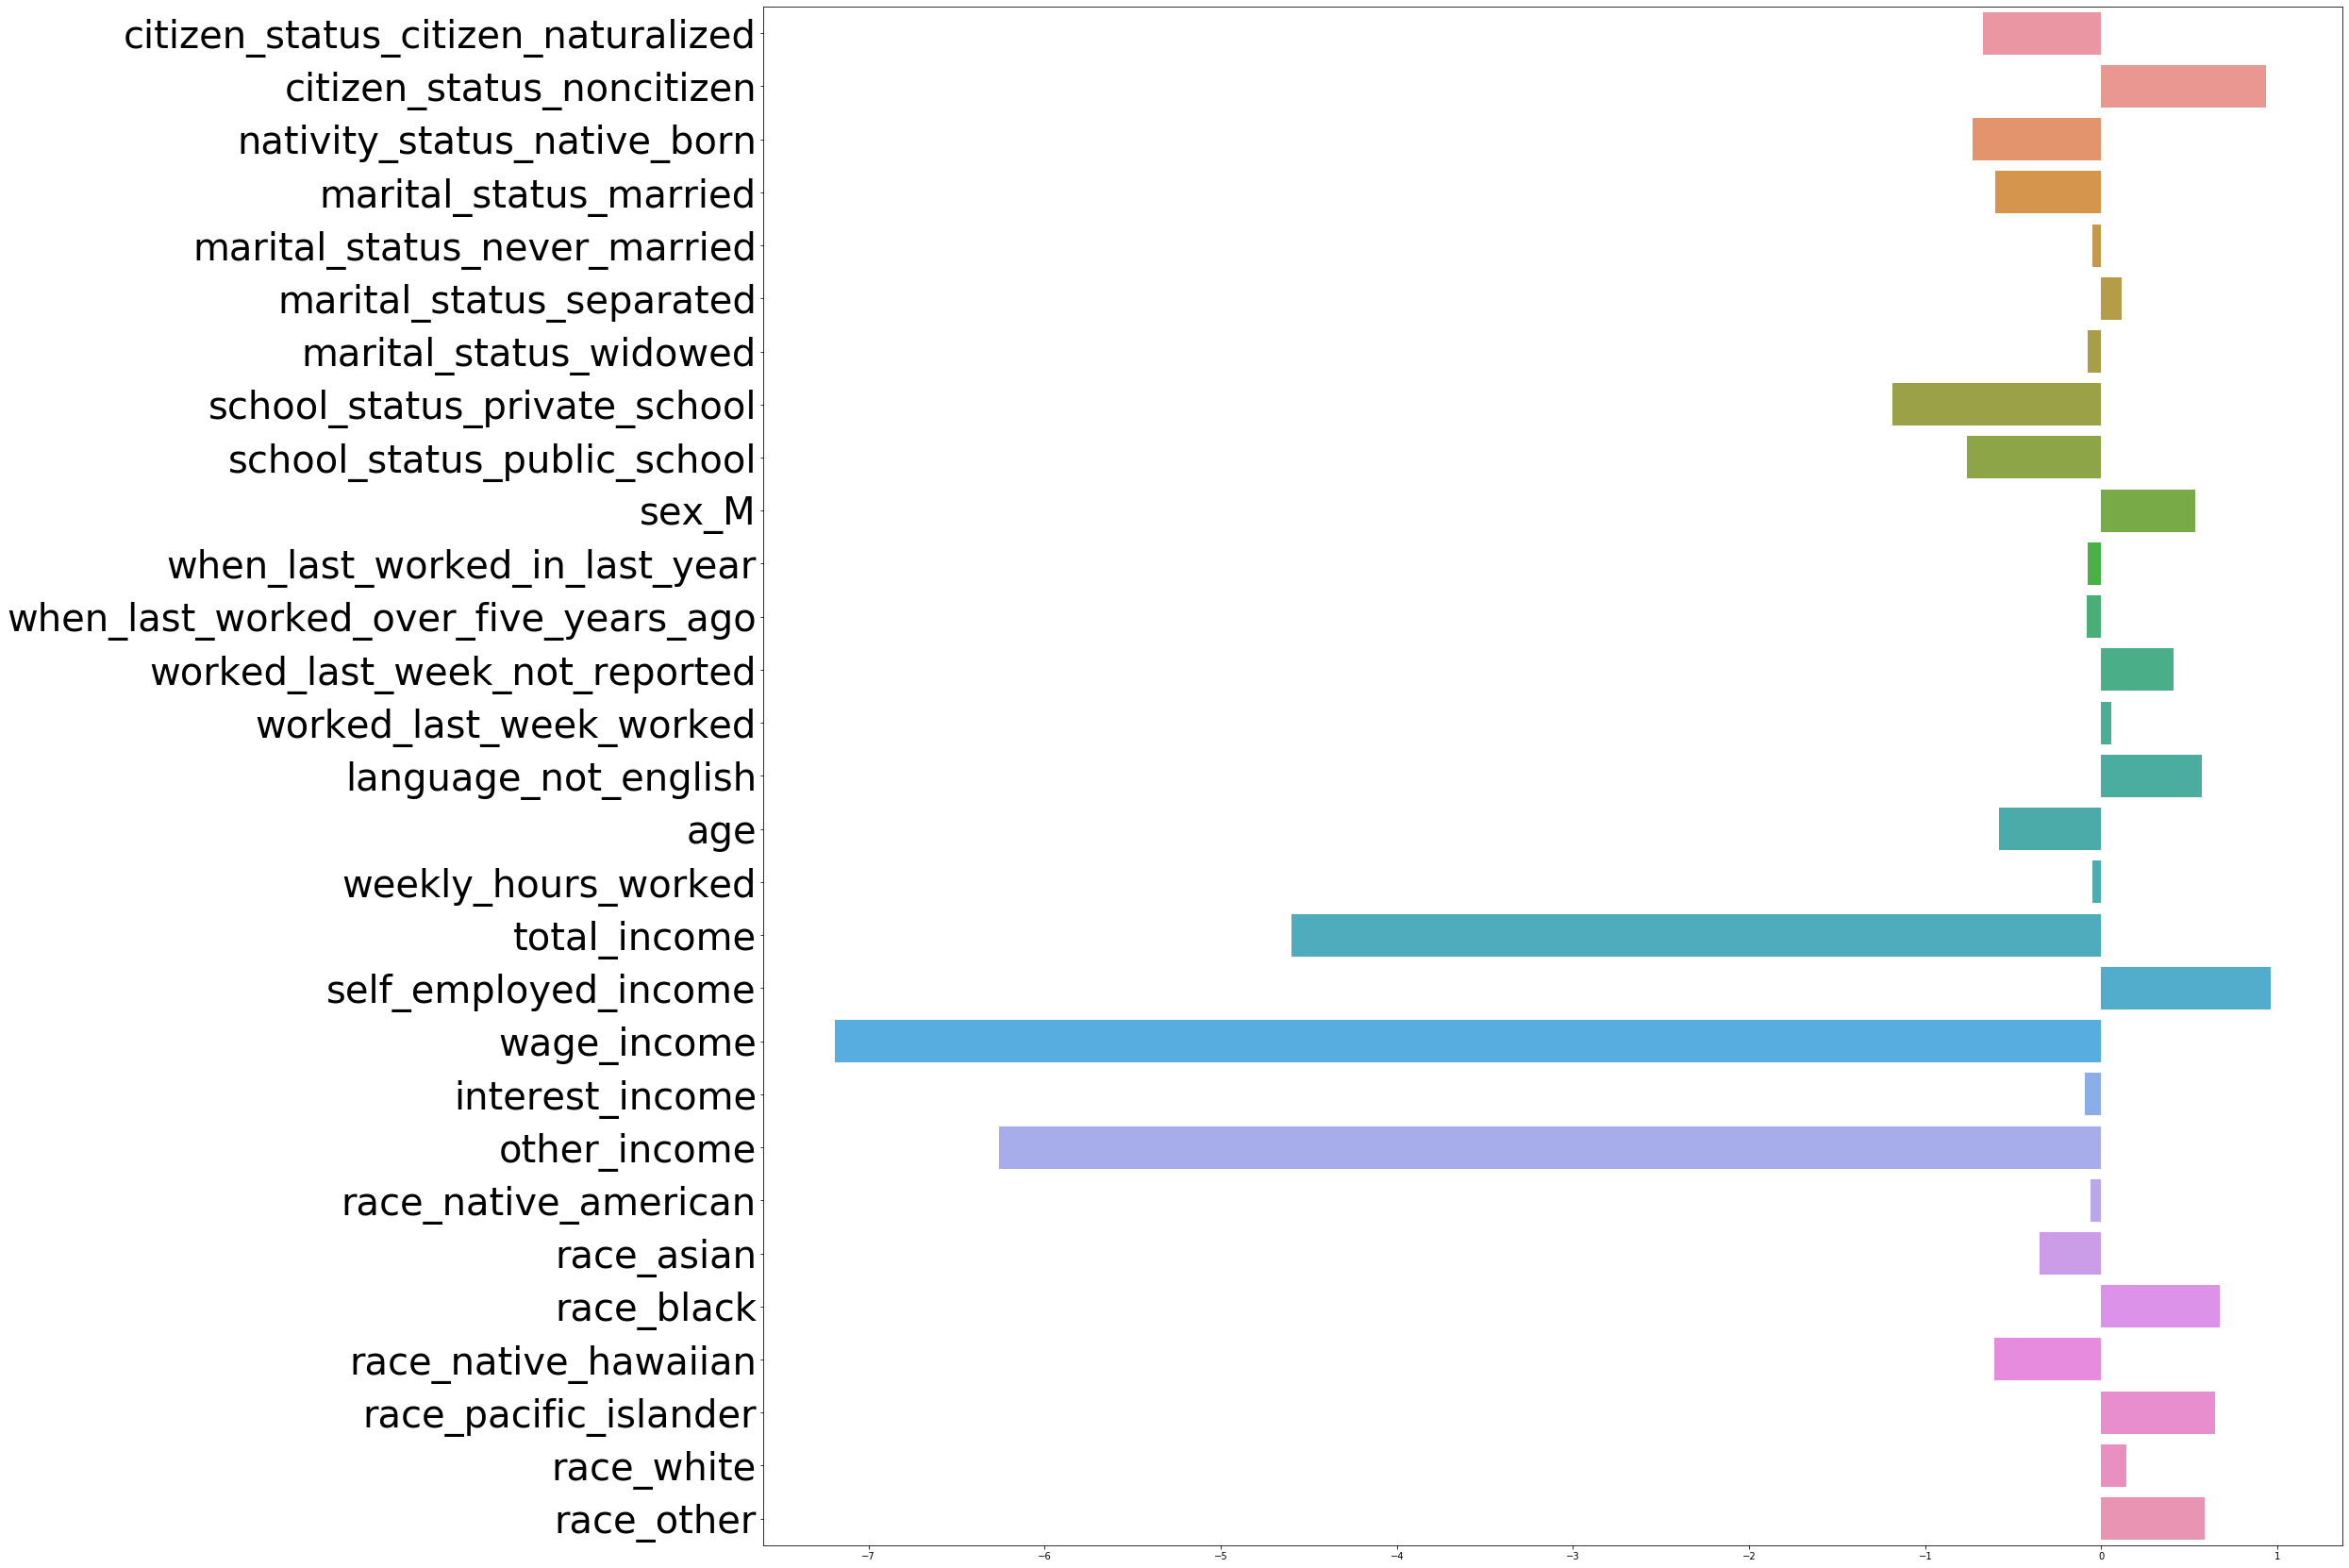

In [456]:
plt.figure(figsize=(30,30))
sns.barplot(x=coef, y=X_train.columns)
plt.yticks(fontsize=40)
plt.show()

0: Has health insurance.


1: Does not have health insurance.

A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease

In [488]:
unlabeled.head(2)

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,household_id
0,12,28,citizen_birth,native_born,45,15254.0,15081.0,82.0,16.0,75.0,never_married,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,6
1,13,40,citizen_birth,native_born,32,10291.0,45.0,9068.0,57.0,1121.0,divorced,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,7


In [489]:
unlabeled.sex = unlabeled.sex.replace({'FEMALE': 'F'})
unlabeled.sex = unlabeled.sex.replace({'female': 'F'})

unlabeled.sex = unlabeled.sex.replace({'MALE': 'M'})
unlabeled.sex = unlabeled.sex.replace({'male': 'M'})

unlabeled.head()

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,household_id
0,12,28,citizen_birth,native_born,45,15254.0,15081.0,82.0,16.0,75.0,never_married,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,6
1,13,40,citizen_birth,native_born,32,10291.0,45.0,9068.0,57.0,1121.0,divorced,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,7
2,22,68,citizen_birth,native_born,0,13194.0,80.0,34.0,69.0,13011.0,married,not_student,M,over_five_years_ago,did_not_work,English,0,0,0,0,0,1,0,13
3,23,64,citizen_birth,native_born,40,30194.0,33.0,30094.0,37.0,30.0,married,not_student,F,in_last_year,worked,English,0,0,0,0,0,1,0,13
4,25,29,citizen_birth,native_born,40,52174.0,12.0,52101.0,52.0,9.0,never_married,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,15


In [490]:
for val in unlabeled.language.values:
    if val != 'English':
        unlabeled.language = unlabeled.language.replace({val:'not_english'})

In [491]:
unlabeled_new = unlabeled.drop(['person_id', 'household_id'], axis=1)

In [492]:
cont = unlabeled_new.select_dtypes(exclude='object')

cat = unlabeled_new.select_dtypes(include='object')

In [493]:
for col in cont.columns:
    cont[col]= (cont[col]-min(cont[col]))/(max(cont[col]-min(cont[col])))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [494]:
ehe = OneHotEncoder(drop='first')
tran = ehe.fit_transform(cat).toarray()
tran_df= pd.DataFrame(tran, columns=ehe.get_feature_names(cat.columns))
tran_df.head(2)

,citizen_status_citizen_naturalized,citizen_status_noncitizen,nativity_status_native_born,marital_status_married,marital_status_never_married,marital_status_separated,marital_status_widowed,school_status_private_school,school_status_public_school,sex_M,when_last_worked_in_last_year,when_last_worked_over_five_years_ago,worked_last_week_not_reported,worked_last_week_worked,language_not_english
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [495]:
tran_df.reset_index(inplace=True, drop=True)


In [496]:
cont.reset_index(inplace=True, drop=True)

In [497]:
new = tran_df.join(cont)

In [498]:
new.head(2)

,citizen_status_citizen_naturalized,citizen_status_noncitizen,nativity_status_native_born,marital_status_married,marital_status_never_married,marital_status_separated,marital_status_widowed,school_status_private_school,school_status_public_school,sex_M,when_last_worked_in_last_year,when_last_worked_over_five_years_ago,worked_last_week_not_reported,worked_last_week_worked,language_not_english,age,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.131579,0.454545,0.014366,0.048633,0.000162,0.000065,0.000353,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.289474,0.323232,0.009685,0.000145,0.017953,0.000233,0.005276,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [499]:
%store new

Stored 'new' (DataFrame)


In [500]:
predictions = logreg.predict_proba(new)

predicted = logreg.predict(new)

predicted

array([0, 0, 0, ..., 0, 0, 0])

In [575]:
df = pd.DataFrame(predictions)

df['person_id'] = unlabeled.person_id

df['score'] = predicted


pd.set_option('display.max_rows', 500)

df = df[['person_id', 'score']]
df

,person_id,score
0,12,0
1,13,0
2,22,0
3,23,0
4,25,0
...,...,...
20167,126592,0
20168,126623,0
20169,126624,0
20170,126640,0


The first column corresponds to the probability that the sample belongs to the first class and the second column corresponds to the probability that the sample belongs to the second class.

Please write your answers in this document, and include your code (including any exploratory or
data-munging code) as part3_code.txt. 


In addition, please apply your model to the observations in
unlabeled_data.csv to produce individual probability predictions of uninsurance. 

After that, place
the person_id column and the associated scores into a file called part3_scores.csv. The headers on
this csv should be “person_id” and “score” for person_id and predicted scores, respectively.

In [720]:
# from sklearn import svm

# #Create a svm Classifier
# clf = svm.SVC(kernel='rbf', probability=True) # Linear Kernel

# #Train the model using the training sets
# clf.fit(X_train, y_train)

# #Predict the response for test dataset
# y_pred = clf.predict(X_test)

In [721]:
# clf.score(X_test, y_test)

In [719]:
# from sklearn import metrics

# # Model Accuracy: how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [715]:
# # Model Precision:
# print("Precision:",metrics.precision_score(y_test, y_pred))

# # Model Recall
# print("Recall:",metrics.recall_score(y_test, y_pred))

In [716]:
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# log_confusion = confusion_matrix(y_test, y_pred, normalize='true')
# class_report = classification_report(y_test, y_pred)

# print(log_confusion)
# print(class_report)

In [717]:
# predictions = clf.predict_proba(new)

# predicted = clf.predict(new)

# predicted

In [718]:
# df = pd.DataFrame(predictions)

# df['person_id'] = unlabeled.person_id

# df['score'] = predicted


# pd.set_option('display.max_rows', 500)

# # df.head(50)